<a href="https://colab.research.google.com/github/vedantdave77/project.Orca/blob/master/Generative%20Adversarial%20Networks/Deep_Convolution_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolution General Adversarial Network

## AIM:

In this Notebook, My main aim is to generate DCGAN, which is represented first time in 2016. The original paper name is "UNSUPERVISED REPRESENTATION LEARNING
WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS". 

I will use the real image dataset from google street view. The data are preprocessed for use by PyTorch. I will access data from PyTorch's regular library. I will implement idea of "DCGAN", which has deeper insight than normal GAN created before with MNIST dataset. Please also check it in the same GAN folder. 

The model will consist the same ideaology of two opposite networks, tries to overtake each other and at last found one equilibrium state. The network names are "Generator" and "Descriminator". Its a extended version of "Game Theory" used by Computer Science comunity.

You can access data from [Stanford Dataset](http://ufldl.stanford.edu/housenumbers/). Incase, if you are going to use Tensorflow or Keras. Thank you.

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle as pkl

## Prepare and load Data.

In [2]:
# import SVHN data from pytorch internal library
from torchvision import datasets
from torchvision import transforms

# Transform data
transform = transforms.ToTensor()

# load data
train_data = datasets.SVHN(root = '/data', split='train', download = True, transform = transform)
batch_size = 128
num_workers = 2

# built dataloader 
train_loader = torch.utils.data.DataLoader(train_data,batch_size =batch_size, shuffle= True, num_workers= num_workers)

## Data Visualizatin and Preprocess

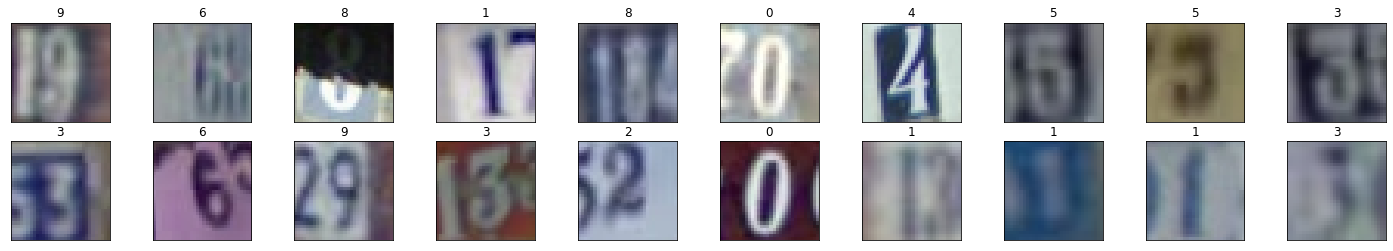

In [3]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25,4))
plot_size = 20                                                                  # no. of images
for idx in np.arange(plot_size):
  ax = fig.add_subplot(2,plot_size/2,idx+1,xticks=[],yticks=[])
  ax.imshow(np.transpose(images[idx],(1,2,0)))
  ax.set_title(str(labels[idx].item()))

In [4]:
images[1].size()

torch.Size([3, 32, 32])

From, above I get the information regarding, images. All the images are in RGB type, and fully focused (centric) image is considered as output. Each image has different resolution and the images are with 32*32 in size. So, images required scalling and I will use tanh activatoin in generator output, which gives result in (-1,1). So, I must need image within such range. 

#### preprocessing to (-1,1) scaling.

Current version is between (0,1) which we need to converts to (-1 to 1)

In [5]:
img = images[0]

print('min ', img.min())
print('max ',img.max())

min  tensor(0.1725)
max  tensor(0.7529)


In [6]:
def scaling(x, range=(-1,1)):
  min,max = range
  x = x* (max-min) + min
  return x 

In [7]:
scalled_image = scaling(img)

print('min ', scalled_image.min())
print('max ', scalled_image.max())

min  tensor(-0.6549)
max  tensor(0.5059)


## Define the Model Architecture



### Discriminator 

Here, first I will make one convolution function. Becuase, I want to use batch_normalization during layers. And, PyTorch does not have such convolution facility. So, we should use onther kind of stretagy. Custom convolution will recall later in to the network "__init__" function. 

I will use BECwithLogitLoss function for criterion loss function. Before that I will use layer wise increments. Means, I will increse the depth layer by layer.Only at output layer I will use softmax for getting classwise probability.

In [8]:
# generate helper function for the layers 
def conv(in_channels, out_channels, kernel_size, stride = 2 , padding= 1, batch_norm= True):
  layers = []
  conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False)
  layers.append(conv_layer)
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))                                 # aided layer
  return nn.Sequential(*layers)

In [9]:
class Discriminator(nn.Module):
  def __init__(self,conv_dim = 32):
    super(Discriminator,self).__init__()

    # complete init function
    self.conv_dim = conv_dim 

    # start with 32x32 input
    self.conv1 = conv(3, conv_dim, 4, batch_norm=False)                         # batch_norm = False, means work as normal convolution network.
    # down to 16x16 (increasing depth)
    self.conv2 = conv(conv_dim, conv_dim*2, 4)
    # down to 8x8 (increasing depth)
    self.conv3 = conv(conv_dim*2,conv_dim*4, 4)
    # final result (with Linearity)
    self.convLin = nn.Linear(conv_dim*4*4*4, 1)                                 # because we will flatten output after that. 

  def forward(self,x):
    x = F.leaky_relu(self.conv1(x),0.2)
    x = F.leaky_relu(self.conv2(x),0.2)
    x = F.leaky_relu(self.conv3(x),0.2)
    
    # flatten the result
    x = x.view(-1, self.conv_dim*4*4*4)
    out = self.convLin(x)
    return out

### Generator 

What's new here is we'll use transpose convolutional layers to create our new images.

- The first layer is a fully connected layer which is reshaped into a deep and narrow layer, like 4x4x512.
- Then, I will use batch normalization and a leaky ReLU activation.
- Next is a series of transpose convolutional layers, where we can typically halve the depth and double the width and height of the previous layer.
- And, I will apply batch normalization and ReLU to all but the last of these hidden layers. Where we will just apply a tanh activation.

Here, I will also use deconv functino which gives priority to generate model with batch_normalization. 

In [10]:
def deconv(in_channels, out_channels, kernel_size, stride =2, padding = 1, batch_norm = True):
  layers = []
  transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = False)
  layers.append(transpose_conv_layer)
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*layers)

In [11]:
class Generator(nn.Module):
  def __init__(self,z_size, conv_dim = 32):
    super(Generator,self).__init__()
    self.conv_dim = conv_dim 

    # start with fully connnected layers (reverse than discriminator)
    self.convLin = nn.Linear(z_size,conv_dim*4*4*4)

    # transpose layers (reverse)
    self.t_conv1 = deconv(conv_dim*4,conv_dim*2,4)
    self.t_conv2 = deconv(conv_dim*2,conv_dim,4)
    self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False) 

  def forward(self,x):
    x = self.convLin(x)
    x = x.view(-1,self.conv_dim*4, 4,4)
    x = F.relu(self.t_conv1(x))
    x = F.relu(self.t_conv2(x))
    out = F.tanh(self.t_conv3(x))
    return out 

## Build Complete Network

In [12]:
conv_dim = 32
z_size = 100

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D)
print("==========================================================================================")
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convLin): Linear(in_features=2048, out_features=1, bias=True)
)
Generator(
  (convLin): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1,

## Descriminator and Generator Losses 



### Disriminator Losses

For the discriminator, the total loss is the sum of the losses for real and fake images, d_loss = d_real_loss + d_fake_loss.

I want the discriminator to output 1 for real images and 0 for fake images, so I need to set up the losses to reflect that.

The losses will by binary cross entropy loss with logits, which we can get with BCEWithLogitsLoss. This combines a sigmoid activation function and and binary cross entropy loss in one function.

For the real images, I want D(real_images) = 1. and  D(fake_images) = 0, where the fake images are the generator output, fake_images = G(z).


### Generator Loss
The generator loss will look similar only with flipped labels. The generator's goal is to get D(fake_images) = 1. In this case, the labels are flipped to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [13]:
def real_loss(D_out, smooth=False):
  batch_size = D_out.size(0)
  if smooth: 
    labels = torch.ones(batch_size)*0.9
  else:
    labels = torch.ones(batch_size)

  if train_on_gpu:
    labels = labels.cuda()
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)
  return loss 

def fake_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size)
  if train_on_gpu:
    labels = labels.cuda()
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(),labels)
  return loss   

## Optimizers 
I am using a small learning rate and custom parameters for the Adam optimizers, This is based on some research into DCGAN model convergence. Due to normalization, we can use small learning rate or higher learning rate will converg the model faster.

## Hyper Parameters 
GANs are very sensitive to hyperparameters, which are learning_rate, and beta.

In [14]:
import torch.optim as optim

# parameters
lr = 0.0002
beta1=0.5  
beta2=0.999 # default value in GAN Paper

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Training 
**Discriminator training**

1. Compute the discriminator loss on real, training images
2. Generate fake images
3. Compute the discriminator loss on fake, generated images
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

**Generator training**
1. Generate fake images
2. Compute the discriminator loss on fake images, using flipped labels!
3. Perform backpropagation + an optimization step to update the generator's weights

**Saving Samples**
As I train, I will also print out some loss statistics and save some generated "fake" samples.

**Evaluation mode**

Important to understand that, when we call our generator to create the samples to display, we set our model to evaluation mode: G.eval(). 

That's so the batch normalization layers will use the population statistics rather than the batch statistics (as they do during training), 

... and so **dropout layers will operate** in eval() mode; ***not turning off any nodes*** for generating samples.

In [15]:
# checking gpu avalability
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')


GPU available for training. Models moved to GPU


In [16]:
num_epochs = 50
print_every = 100
sample_size = 16

samples = []
losses = []

fixed_z = np.random.uniform(-1,1,size = (sample_size,z_size))
fixed_z = torch.from_numpy(fixed_z).float()                                     # convert numpy to torch array type (float)

# define train loop 
for epoch in range(num_epochs):
  for batch_i, (real_images, _) in enumerate(train_loader):
    batch_size = real_images.size(0)

    # scalling 
    real_images = scaling(real_images)

    # TRAIN THE DISCRIMINATOR
    d_optimizer.zero_grad()
    # real images 
    if train_on_gpu:
      real_images = real_images.cuda()
    D_real = D(real_images)
    d_real_loss = real_loss(D_real)

    # fake images 
    z = np.random.uniform(-1,1,size= (batch_size,z_size))
    z = torch.from_numpy(z).float()
    if train_on_gpu:
      z = z.cuda()
    fake_images = G(z)
    D_fake = D(fake_images)
    d_fake_loss = fake_loss(D_fake)

    # total loss 
    d_loss = d_real_loss + d_fake_loss
    # update  
    d_loss.backward()
    d_optimizer.step()

    # ==================================================

    # TRAIN ON GENERATOR
    g_optimizer.zero_grad()

    z = np.random.uniform(-1,1,size = (batch_size, z_size))
    z = torch.from_numpy(z).float()
    if train_on_gpu:
      z = z.cuda()
    fake_images = G(z)
    D_fake = D(fake_images)
    g_loss = real_loss(D_fake)
    
    g_loss.backward()
    g_optimizer.step()

    if batch_i % print_every == 0:
      losses.append((d_loss.item(),g_loss.item()))
      print( 'Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))
      
  # After each epochs
  # generate the samples and save to file system
  G.eval()
  if train_on_gpu:
    fixed_z = fixed_z.cuda()
  sample_z = G(fixed_z)
  samples.append(sample_z)
  G.train()                                                                     # back to training mode 

with open('train_sample.pkl', 'wb') as f:
  pkl.dump(samples, f)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   50] | d_loss: 1.4107 | g_loss: 1.0659
Epoch [    1/   50] | d_loss: 0.0413 | g_loss: 4.9436
Epoch [    1/   50] | d_loss: 0.1378 | g_loss: 3.5449
Epoch [    1/   50] | d_loss: 0.2161 | g_loss: 2.9582
Epoch [    1/   50] | d_loss: 1.2717 | g_loss: 4.0279
Epoch [    1/   50] | d_loss: 0.3332 | g_loss: 2.8506
Epoch [    2/   50] | d_loss: 1.0575 | g_loss: 4.5454
Epoch [    2/   50] | d_loss: 0.5189 | g_loss: 2.0970
Epoch [    2/   50] | d_loss: 0.7880 | g_loss: 3.0310
Epoch [    2/   50] | d_loss: 0.7174 | g_loss: 1.2409
Epoch [    2/   50] | d_loss: 0.6462 | g_loss: 2.7534
Epoch [    2/   50] | d_loss: 0.6350 | g_loss: 2.2801
Epoch [    3/   50] | d_loss: 0.6329 | g_loss: 2.5084
Epoch [    3/   50] | d_loss: 0.3983 | g_loss: 2.1583
Epoch [    3/   50] | d_loss: 0.2792 | g_loss: 2.6004
Epoch [    3/   50] | d_loss: 0.3660 | g_loss: 2.3196
Epoch [    3/   50] | d_loss: 0.2455 | g_loss: 2.3926
Epoch [    3/   50] | d_loss: 0.3141 | g_loss: 3.2361
Epoch [    4/   50] | d_loss

### Training Loss Visualization

Here I am ploting the training losses for the generator and discriminator per epochs

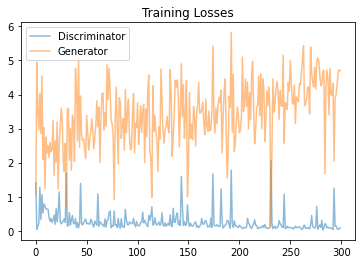

In [17]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### **Observation**: 
Here, discriminator is powerful and generator is not that much accurate until now, but there are some spike which gives good result, so early stoping is possible. But, on most of good generator result spikes, the discriminator also have problem with individual accuracy. So, we need more deeper network. **Still just for now, let's generate samples ...** 

## Generate Samples

We have samples in pikle form so, let's generate some samples using Generator. The accuracy of Samples totally depends on the Generator training algorithm's accuracy, and Discriminator classifier's ability to distiguish the real and fake images.  

In [19]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(20,8), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

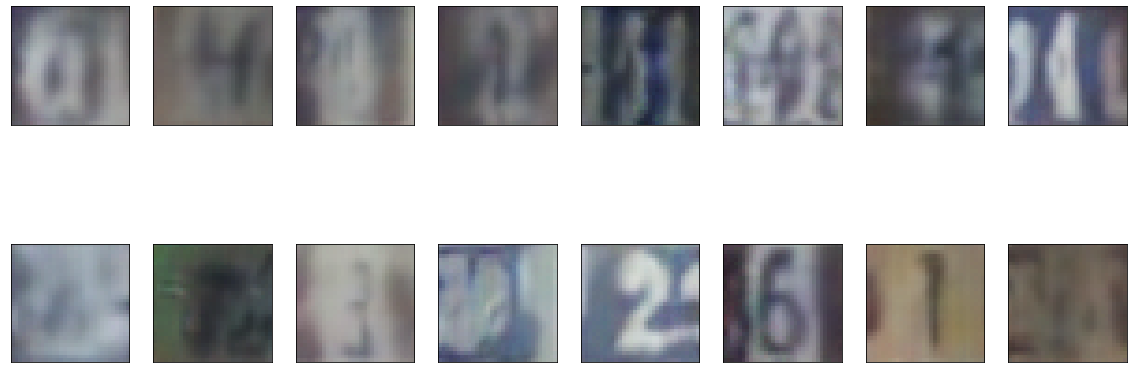

In [20]:
result = view_samples(-1, samples)

## **Conclusion**:

Here, we can see that new generated images are quiet blur and its due to the model's accuracy. Because, the Discriminator are very helpful to regognize the fake image, but generator is not that much powerful. So, we have following solutions:
1. Train for more epochs
2. Use more deeper Network
3. Tune hyper parameteres 

Moreover, the Paper suggest to use powerful network with 1024 initialization to 1. Such computation need more time and computation power. So, I will do it later with another gpu time. Currently I am using colab general version. Thank you for connect with me. 

Have a nice coding!

In [ ]:
# Keep Learning, Enjoy Empowering. 